# Quantum algorithms for fast convolutions and hidden shifts

Welcome, this notebook explores the execution of _hidden shift problems_ on a quantum computer.
This notebook does assume some quantum knowledge.  We invite you to have a look into our 👋🌎 _Hello world_ samples in the notebook gallery and the [Quantum Katas](https://docs.microsoft.com/azure/quantum/tutorial-qdk-intro-to-katas) for introductory content on quantum computing.

One way to think about the space of hidden shift problems
is that we are using the quantum computer to help us compute the convolution of two functions. 
It turns out that a quantum computer can in principle compute convolutions in a super-fast way, which in turn is based on the quantum computer's ability to 
compute Fourier transforms in a super-fast way. The way convolutions are used is to find unknown shifts ("offsets") between two functions. We call this the 
"hidden shift problem." Like Shor's algorithm for factoring, the hidden shift problem is a natural source of problems for which a quantum computer has an 
exponential advantage over the best known classical algorithms. 
This may eventually help in solving deconvolution problems and enable us to efficiently find patterns in complex data sets,
for example finding the pattern on the right-hand side in the graph:

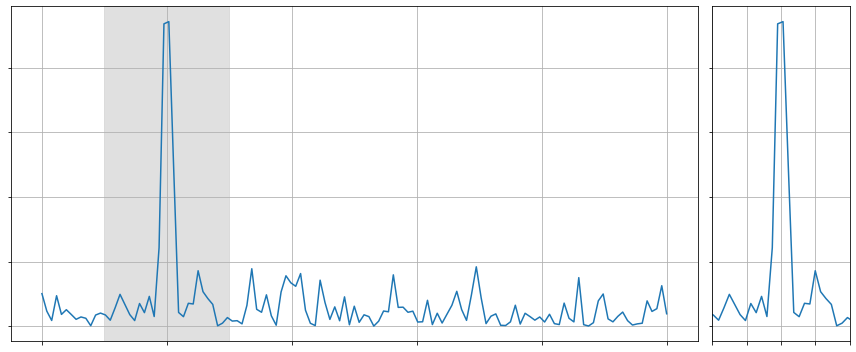

You can have a look into [arXiv:0812.0380](https://arxiv.org/abs/0812.0380) for general background on hidden shifts and related problems
and into [arXiv:0811.3208](https://arxiv.org/abs/0811.3208) for the case of hidden shifts over Boolean functions.

We will investigate the latter case, in which one is given two Boolean bent functions $f$ and $g$ with the promise that they satisfy the relation

$$ g(x) = f(x \oplus s) $$

for all $x$, where $s$ is a hidden bitstring, called _shift_ that we would like to find.
A Boolean function is _bent_ if it is as far from linear as possible. In
particular, bent functions have flat Fourier spectra, such that each
Fourier coefficient is equal in absolute value.

In this case, the quantum algorithm described in [arXiv:0811.3208](https://arxiv.org/abs/0811.3208) uses
black-box phase oracles $U_{f^\star}$ and $U_g$ for $f^\star$ and $g$, respectively, where $f^\star$ is the dual bent function
to $f$ (defined in more detail below), and computes the hidden shift $s$ between $f$ and $g$.

The quantum circuit for this type of hidden shift problems is as follows:

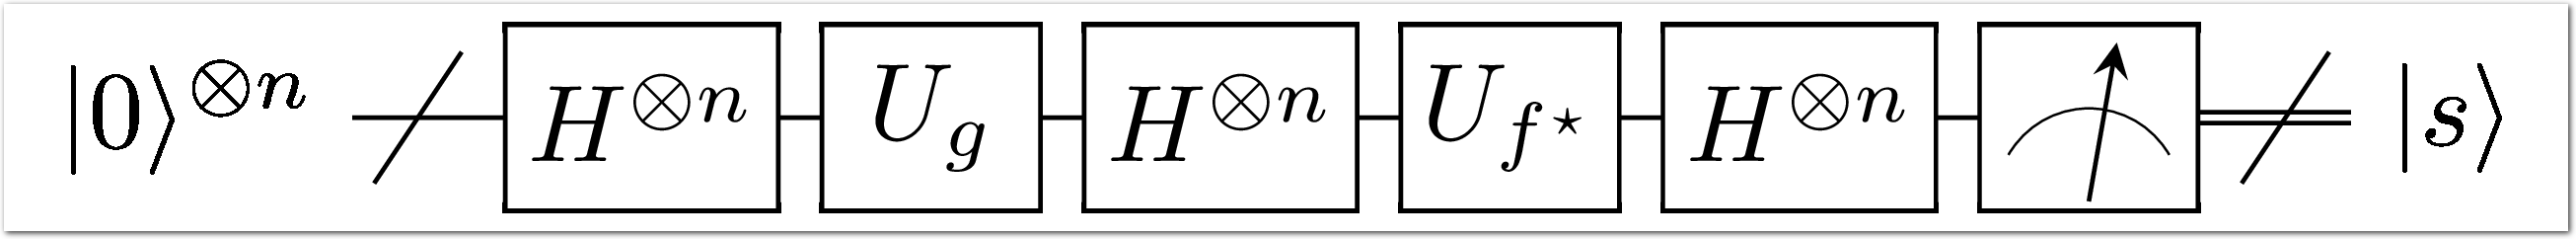

Black-box phase oracles compute the value of a Boolean function $f(x)$ into the phase, i.e., $U_f = \sum_x (-1)^{f(x)}|x\rangle\langle x|$.
More information on phase oracles can be found in the [Quantum Katas](https://github.com/microsoft/QuantumKatas/tree/main/tutorials/Oracles).

You can have a look into [arXiv:0812.0380](https://arxiv.org/abs/0812.0380) for general background on hidden shifts and related problems
and into [arXiv:0811.3208](https://arxiv.org/abs/0811.3208) for the case of hidden shifts



## 1. Connect to the Azure Quantum workspace

Let's start by connecting to the Azure Quantum service.
We construct an instance of the `AzureQuantumProvider`. Note that it's imported from `azure.quantum.qiskit`.

In [1]:
from azure.quantum.qiskit import AzureQuantumProvider
provider = AzureQuantumProvider(
    resource_id = "",
    location = ""
)

Next we are going to import some packages to describe and visualize quantum circuits from the `qiskit` package.
We'll also import packages from _NumPy_ and _Matplotlib_ to create plots from the experimental data.
Finally, we'll list the targets included in our workspace.

In [2]:
from qiskit import QuantumCircuit, QuantumRegister
from qiskit.compiler import transpile
from qiskit.tools.monitor import job_monitor
from qiskit.visualization import plot_histogram

import numpy as np
from numpy.linalg import norm
import matplotlib.pyplot as plt

print("This workspace's targets:")
for backend in provider.backends():
    print("- " + backend.name())

This workspace's targets:
- quantinuum.qpu.h1-1
- quantinuum.sim.h1-1sc
- quantinuum.qpu.h1-2
- quantinuum.sim.h1-2sc
- quantinuum.sim.h1-1e
- ionq.qpu
- ionq.simulator


We will be using some of these targets in this notebook, but whenever you see such a target's name, note that you can easily exchange them by other targets in this list. (Note, however, that some of these targets are API validators and do not simulate or execute quantum functionality.)
You can learn more about the various targets in the 👋🌎 _Hello world_ samples.

## 2. Build a simple hidden shift problem

Let's first create a function that creates hidden shift problems by passing to it phase oracle circuits for $U_g$ and $U_{f^\star}$.

In [3]:
def hidden_shift(oracle_g, oracle_fstar):
    """Creates a hidden shift circuit based on phase oracle circuits for `oracle_g` and `oracle_fstar`."""

    # Obtain the number of qubits from oracle_g
    num_qubits = oracle_g.num_qubits

    # Check that number of qubits are the same for both oracles
    assert num_qubits == oracle_fstar.num_qubits, "Number of qubits for both oracles must be equal"

    # A quantum register for all qubits we are using in this circuit.
    qs = QuantumRegister(num_qubits, name="q")

    # This constructs the quantum circuit
    circ = QuantumCircuit(qs, name="Hidden shift")

    # A layer of H gates
    circ.h(qs)

    # Apply $U_g$ (rename it for visualization)
    oracle_g.name = "Ug"
    circ.append(oracle_g, qs)

    # Another layer of H gates
    circ.h(qs)

    # Apply $U_{f^\star}$
    oracle_fstar.name = "Uf*"
    circ.append(oracle_fstar, qs)

    # And a final layer of H gates
    circ.h(qs)
    circ.measure_all()

    return circ

We have now a powerful routine to describe various hidden shift problems based on Boolean bent functions.
The first bent function we will investigate is the inner product

$$ f(x_1, \dots, x_{2k}) = (x_1 \land x_2) \oplus (x_3 \land x_4) \oplus \cdots \oplus (x_{2k-1} \land x_{2k}) $$

An appealing property about this function is it's equal to its dual, i.e., $f^\star = f$.
The following helper circuit implements this function as a phase oracle $U_f$ by using CZ gates for each AND pair in the inner product.
Its effect to the computational basis state $|x\rangle$ is $(-1)^{f(x)}|x\rangle$.
In the following Python code the argument `num_qubits` corresponds to $2k$.

In [4]:
def inner_product(num_qubits):
    """Creates the inner product of two qubit registers, which are the alternating qubits over `num_qubits` bits"""

    # Number of qubits must be even
    assert num_qubits % 2 == 0, "Number of qubits must be even"

    # Create a quantum circuit
    circ = QuantumCircuit(num_qubits, name='inner_product')
    # Apply CZ gates to pairs of even and odd qubit indices
    for c, t in zip(circ.qubits[::2], circ.qubits[1::2]):
        circ.cz(c, t)
    return circ

Next, we want to implement $g(x) = f(x \oplus s)$ for some shift $s$.
For this purpose, we first construct a building block that computes the XOR operation with $s$ (passed as argument `shift`) in-place into a quantum register of length `num_bits`.
More precisely, the action of this building block on the computational basis state $|x\rangle$ is $|x \oplus s\rangle$, where $\oplus$ is the bit-wise XOR operation.

In [5]:
def xor(shift, num_bits):
    """Bitwise XOR of `num_bits`-bit value `shift`"""

    # Shift must be smaller than 2^num_bits
    assert shift >= 0 and shift < 2**num_bits, f"Shift must be between 0 and {2**num_bits - 1}"

    # Create a quantum circuit with `num_bits` qubits
    circ = QuantumCircuit(num_bits, name=f'xor({shift})')
    # Returns all indexes which correspond to a `1` in the binary expansion of `shift`
    ones = [idx for idx in range(num_bits) if (shift >> idx) & 1 == 1]
    # Apply an X operation to all indexes in `ones` (this only works if `ones` is not empty)
    if ones:
        circ.x(ones)

    return circ

The next helper function takes as input a phase oracle $U_f$ and creates a phase oracle $U_g$ such that $g(x) = f(x \oplus s)$ by conjugating the phase oracle with the XOR operation we just defined.

In [6]:
def shifted_phase_oracle(shift, phase_oracle):
    """Creates U_g from U_f (phase_oracle), where g(x) = f(x ⊕ s)"""
    # Retrieve qubits from input phase oracle
    qs = phase_oracle.qubits
    # Create a quantum circuit using the qubits from the phase oracle
    circ = QuantumCircuit(qs)
    # Compute shift into the computational state using the XOR operation
    circ.append(xor(shift, phase_oracle.num_qubits), qs)
    # Apply the phase oracle onto the shifted state
    circ.append(phase_oracle, qs)
    # Uncompute the shift by applying the XOR operation another time
    circ.append(xor(shift, phase_oracle.num_qubits), qs)

    return circ

We are now equipped to build a first simple hidden shift problem using the inner product as bent function.
We configure the problem by its size `num_qubits`, which should be an even number, and represents the overall number of qubits $n$ in the circuit,
and `shift` which is a non-negative number smaller than $2^n$.

In [7]:
num_qubits = 4
shift = 5

# Create phase oracle circuit for $f^\star$
oracle_fstar = inner_product(num_qubits)

# Create phase oracle circuit for $g$
oracle_g = shifted_phase_oracle(shift, oracle_fstar)

# Create hidden shift circuit
circ = hidden_shift(oracle_g, oracle_fstar)

# Print out the circuit (and ensure that the circuit is not paginated)
circ.draw(fold=-1)

┌───┐┌─────┐┌───┐┌──────┐┌───┐ ░ ┌─┐         
   q_0: ┤ H ├┤0    ├┤ H ├┤0     ├┤ H ├─░─┤M├─────────
        ├───┤│     │├───┤│      │├───┤ ░ └╥┘┌─┐      
   q_1: ┤ H ├┤1    ├┤ H ├┤1     ├┤ H ├─░──╫─┤M├──────
        ├───┤│  Ug │├───┤│  Uf* │├───┤ ░  ║ └╥┘┌─┐   
   q_2: ┤ H ├┤2    ├┤ H ├┤2     ├┤ H ├─░──╫──╫─┤M├───
        ├───┤│     │├───┤│      │├───┤ ░  ║  ║ └╥┘┌─┐
   q_3: ┤ H ├┤3    ├┤ H ├┤3     ├┤ H ├─░──╫──╫──╫─┤M├
        └───┘└─────┘└───┘└──────┘└───┘ ░  ║  ║  ║ └╥┘
meas: 4/══════════════════════════════════╩══╩══╩══╩═
                                          0  1  2  3

## 3. Submit the quantum program to IonQ's and Quantinuum's simulators

Next, we are executing this circuit on IonQ's full-state simulator `ionq.simulator` and on Quantinuum's simulator `quantinuum.sim.h1-1e`.
Afterwards, we will write a loop in which we run several experiments using various shifts.
Before sending the circuit to a backend, we must expand all building blocks.
The easiest way to do this is by transpiling the quantum circuit into the target gate set of the backend's quantum computer.
To this end, we construct a backend, and call the `transpile` function to obtain
an expanded and possibly optimized quantum circuit (note that the `X` gates were merged with the `H` gates).
Note that any target you have enabled in this workspace can
be used here. Azure Quantum makes it extremely easy to submit
the same quantum program to different providers.

In [8]:
ionq_backend = provider.get_backend("ionq.simulator")

transpiled = transpile(circ, ionq_backend)
transpiled.draw()

┌─────────┐   ┌──────────┐   ┌───┐ ░ ┌─┐         
   q_0: ┤ Ry(π/2) ├─■─┤ Ry(-π/2) ├─■─┤ H ├─░─┤M├─────────
        └──┬───┬──┘ │ └──┬───┬───┘ │ ├───┤ ░ └╥┘┌─┐      
   q_1: ───┤ H ├────■────┤ H ├─────■─┤ H ├─░──╫─┤M├──────
        ┌──┴───┴──┐   ┌──┴───┴───┐   ├───┤ ░  ║ └╥┘┌─┐   
   q_2: ┤ Ry(π/2) ├─■─┤ Ry(-π/2) ├─■─┤ H ├─░──╫──╫─┤M├───
        └──┬───┬──┘ │ └──┬───┬───┘ │ ├───┤ ░  ║  ║ └╥┘┌─┐
   q_3: ───┤ H ├────■────┤ H ├─────■─┤ H ├─░──╫──╫──╫─┤M├
           └───┘         └───┘       └───┘ ░  ║  ║  ║ └╥┘
meas: 4/══════════════════════════════════════╩══╩══╩══╩═
                                              0  1  2  3

Now we are submitting the transpiled circuit to the selected backend for 100 shots.
We'll get back a `job` instance and print its job ID.

In [9]:
# Using the IonQ simulator target, call "run" to submit the job. We'll
# use 100 shots (simulated runs).
job = ionq_backend.run(transpiled, shots=100)
print("Job id:", job.id())

Job id: a9aceb1c-9ec4-11ec-93c4-acde48001122


The job ID can be used to retrieve the results later using the [`get_job` method](https://learn.microsoft.com/azure/quantum/optimization-workspace#workspaceget_job) or by viewing it under the **Job management** section of the portal.

You can monitor the job status with Qiskit's `job_monitor` function.

This may take a minute or so ⏳. Your job will be packaged and sent to IonQ, where it will wait its turn to be run. You'll see your job go through these stages: "job is queued" -> "job is actively running" -> "job has successfully run."
Once the job has finished, we are retrieving the counts from the backend.
With IonQ's full state simulator, we should see a 100% probability only for the selected shift.

Job Status: job has successfully run


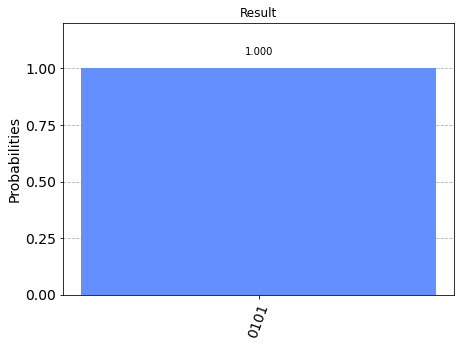

In [10]:
job_monitor(job)
result = job.result()
plot_histogram(result.get_counts(transpiled), title="Result")

Now we'll create a backend for Quantinuum's noisy simulator.  Before we running the circuit, we are going to estimate the cost of simulating the circuit (To learn more about job pricing, review [the Azure Quantum docs](https://docs.microsoft.com/azure/quantum/azure-quantum-job-costs).).

In [11]:
# This time we are creating a backend for Quantinuum's emulator, which also simulates noise.
quantinuum_backend = provider.get_backend("quantinuum.sim.h1-1e")

# We transpile the circuit into the backend's instruction set.
transpiled = transpile(circ, quantinuum_backend)

# And we estimate the cost of simulating the circuit 100 times.
cost = quantinuum_backend.estimate_cost(transpiled, count=100)
print(f"Estimated cost: {cost.estimated_total} {cost.currency_code}")

Estimated cost: 6.64 HQC


The next code section is commented out to prevent accidental costs.  Uncomment the code to run the code on the Quantinuum noisy simulator.

In [12]:
# job = quantinuum_backend.run(transpiled, count=100)
# print("Job id:", job.id())
# job_monitor(job)
# result = job.result()
# plot_histogram(result.get_counts(transpiled), title="Result")

## 4. Create a large experiment and a 3D histogram plot

Based on what we have learned, we are now running a more involved.
We want to explore the quantum circuit measurement results for multiple shifts, possibly all shifts.
We are then plotting the histogram for each experiment in a 3D bar plot,
where one axis shows all possible measurement outcomes, and the other axis lists all experiments for various shifts.
We expect to see some skyscrapers reaching out whenever the shift corresponds to the measurement outcome.

In [13]:
# Number of qubits in the hidden shift experiment
num_qubits = 4
# List of shifts to perform (set to `range(1 << num_qubits)` to run all shifts)
shifts = range(1 << num_qubits)
# Store histogram data for all shifts in a matrix
histogram = np.zeros((len(shifts), 1 << num_qubits))

# Creates an experiment circuit based on shift
def experiment_circuit(shift):
    oracle_f = inner_product(num_qubits)
    oracle_g = shifted_phase_oracle(shift, oracle_f)
    circ = hidden_shift(oracle_g, oracle_fstar)
    transpiled = transpile(circ, ionq_backend)
    return transpiled

# Submit jobs for each shift
jobs = [ionq_backend.run(experiment_circuit(shift), shots=100) for shift in shifts]

# After we submitted all the jobs, we wait for each of them.
# It does not matter whether jobs finishes in a different order than they were executed, since we
# traverse the jobs in the same order as they were executed.
for row, job in enumerate(jobs):
    # Wait for the job to finish
    job_monitor(job)

    # Retrieve all counts from the job
    counts = job.result().get_counts()

    # Retrieve the counts for all input assignments
    histogram[row] = [counts.get(format(idx, f"0{num_qubits}b")) or 0 for idx in range(1 << num_qubits)]

    # Compute probabilities from counts
    histogram[row] /= norm(histogram[row], ord=1)

Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run


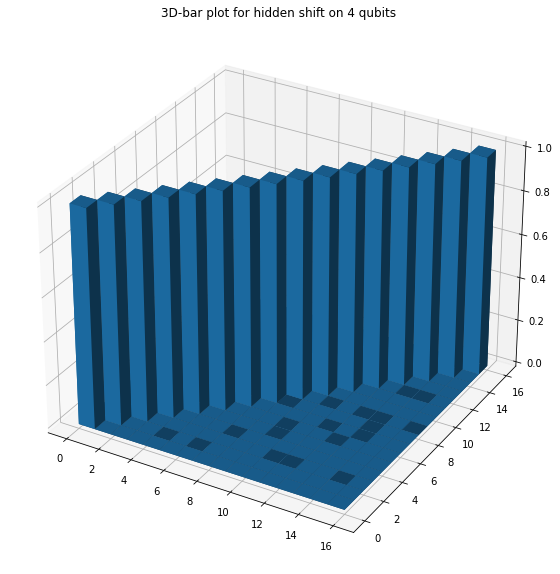

In [14]:
# Set up the figure and axes to print the 3D-bar plot
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(1, 1, 1, projection='3d')

# Create x and y coordinates for the grid based on the dimensions of the matrix
x_grid, y_grid = np.meshgrid(np.arange(1 << num_qubits), np.arange(len(shifts)))

# Flatten matrices into lists
x, y = x_grid.ravel(), y_grid.ravel()
top = histogram.ravel()

bottom = np.zeros_like(top)

ax.bar3d(x, y, bottom, 1, 1, top, shade=True)
ax.set_title(f'3D-bar plot for hidden shift on {num_qubits} qubits')

plt.show()

## 5. Investigating more complex bent functions

The inner product bent function can be generalized to the family of Maiorana-McFarland bent functions
$$ f(x, y) = x\pi(y)^t \oplus h(y) $$
where $x = x_1, \dots, x_k$, $y = y_1, \dots, y_n$, and $\pi \in S_{2^k}$ is a permutation of all possible $2^k$ bitstrings of length $k$.
The inner product $x\pi(y)^t$ is as defined above, and $h$ can be any $k$-input function.
The dual function of a Maiorana-McFarland function is
$$ f^\star(x, y) = \pi^{-1}(x)y^t \oplus h(\pi^{-1}(x)) $$
where $\pi^{-1}$ is the inverse permutation to $\pi$.

The next function can create phase oracles for some of these Maiorana-McFarland functions $f$ and their dual $f^\star$, in which $h = 0$ and $\pi \in S_{2^k}$ is defined via an index permutation $\sigma \in S_k$ such that
$ \pi((b_{k-1}\dots b_0)_2) \mapsto (b_{\sigma(k-1)} \dots b_{\sigma(0)})_2 $.
Such permutations can easily be implemented using SWAP gates on the input qubits and we are using the `Permutation` class to find these SWAP gates automatically.

In [15]:
from qiskit.circuit.library.generalized_gates.permutation import Permutation

def maiorana_mcfarland_bent_function(num_qubits, index_permutation):
    """Creates Maiorana-McFarland bent function based on index permutation"""

    assert num_qubits % 2 == 0, "Number of qubits must be even"

    # Create permutation circuit based on index_permutation.
    # Note that the permutation is only applied on half the qubits
    perm = Permutation(num_qubits // 2, index_permutation)

    # We are considering the even qubits in this circuits corresponding to x in the definition
    # above, and the odd qubits corresponding to y in the definition above.

    # Create phase oracle for f
    circ_f = QuantumCircuit(num_qubits, name="maiorana_mcfarland")
    # Apply permutation to qubits corresponding to x
    circ_f.append(perm, range(0, num_qubits, 2))
    # Apply inner product to x and y
    circ_f.append(inner_product(num_qubits), range(num_qubits))
    # Invert permutation on x
    circ_f.append(perm.reverse_ops(), range(0, num_qubits, 2))

    # Create phase oracle for f_star
    circ_fstar = QuantumCircuit(num_qubits, name="maiorana_mcfarland")
    # Apply inverse permutation to qubits corresponding to y
    circ_fstar.append(perm.reverse_ops(), range(1, num_qubits, 2))
    # Apply inner product to x and y
    circ_fstar.append(inner_product(num_qubits), range(num_qubits))
    # Invert permutation on y
    circ_fstar.append(perm, range(1, num_qubits, 2))

    # Return both circuits
    return circ_f, circ_fstar

Let's try an instance of this new family of bent functions.  We are creating a hidden shift problem with 6 qubits and apply the index permutation $(1, 2, 0)$.  Do you know which answer is hidden in the shift (👍), and also let's see if the quantum computer can discover it?

In [16]:
num_qubits = 6
qubit_permutation = [1, 2, 0]
shift = 0b101010               # The answer ;)

# Create phase oracles for $f$ and $f^star$
oracle_f, oracle_fstar = maiorana_mcfarland_bent_function(num_qubits, qubit_permutation)
# Create phase oracle for $g = f(x ⊕ s)$
oracle_g = shifted_phase_oracle(shift, oracle_f)

# Create hidden shift problem based on oracles
circ = hidden_shift(oracle_g, oracle_fstar)
# Transpile hidden shift circuit for the backend
transpiled = transpile(circ, ionq_backend)

# Submit a job
job = ionq_backend.run(transpiled, shots=100)

# Await the job
job_monitor(job)

# Print the job's result
print(job.result().get_counts())

Job Status: job has successfully run
{'101010': 100}


## 6. Investigating the impact of noise on the quantum algorithm

In this section we do a simple experiment that adds noise to the quantum simulation and see what happens when we crank up
the number of quantum gates in the circuit, in particular, if we increase the number of entangling gates such as CZ or CNOT 
significantly. We expect to see a less clear peak at the correct shift and want to see this in the histogram data coming 
back from emulating the circuit. 

In [17]:
def toffoli_oracles(num_qubits):
    """Create two oracles for the hidden shift problem that use Toffoli gates for a state space permutation."""
    assert num_qubits >= 6, "Number of bits must be at least 6"

    circ_f = QuantumCircuit(num_qubits, name='IP with Toffoli')
    circ_f.ccx(4, 2, 0)
    circ_f.ccx(0, 2, 4)
    circ_f.append(inner_product(num_qubits), range(num_qubits))
    circ_f.ccx(0, 2, 4)
    circ_f.ccx(4, 2, 0)

    circ_fstar = QuantumCircuit(num_qubits, name='IP with Toffoli')
    circ_fstar.ccx(1, 3, 5)
    circ_fstar.ccx(5, 3, 1)
    circ_fstar.append(inner_product(num_qubits), range(num_qubits))
    circ_fstar.ccx(5, 3, 1)
    circ_fstar.ccx(1, 3, 5)

    return circ_f, circ_fstar

Let us next create a concrete instance of the problem with 6 qubits and a shift of 17.  Then, let's draw the circuit.

In [18]:
num_qubits = 6
shift = 17

# Create phase oracles for $f$ and $f^star$
oracle_f, oracle_fstar = toffoli_oracles(num_qubits)
# Create phase oracle for $g = f(x ⊕ s)$
oracle_g = shifted_phase_oracle(shift, oracle_f)

# Create hidden shift problem based on oracles
circ = hidden_shift(oracle_g, oracle_fstar)

# Print out the circuit (and ensure that the circuit is not paginated)
circ.draw(fold=-1)

┌───┐┌─────┐┌───┐┌──────┐┌───┐ ░ ┌─┐               
   q_0: ┤ H ├┤0    ├┤ H ├┤0     ├┤ H ├─░─┤M├───────────────
        ├───┤│     │├───┤│      │├───┤ ░ └╥┘┌─┐            
   q_1: ┤ H ├┤1    ├┤ H ├┤1     ├┤ H ├─░──╫─┤M├────────────
        ├───┤│     │├───┤│      │├───┤ ░  ║ └╥┘┌─┐         
   q_2: ┤ H ├┤2    ├┤ H ├┤2     ├┤ H ├─░──╫──╫─┤M├─────────
        ├───┤│  Ug │├───┤│  Uf* │├───┤ ░  ║  ║ └╥┘┌─┐      
   q_3: ┤ H ├┤3    ├┤ H ├┤3     ├┤ H ├─░──╫──╫──╫─┤M├──────
        ├───┤│     │├───┤│      │├───┤ ░  ║  ║  ║ └╥┘┌─┐   
   q_4: ┤ H ├┤4    ├┤ H ├┤4     ├┤ H ├─░──╫──╫──╫──╫─┤M├───
        ├───┤│     │├───┤│      │├───┤ ░  ║  ║  ║  ║ └╥┘┌─┐
   q_5: ┤ H ├┤5    ├┤ H ├┤5     ├┤ H ├─░──╫──╫──╫──╫──╫─┤M├
        └───┘└─────┘└───┘└──────┘└───┘ ░  ║  ║  ║  ║  ║ └╥┘
meas: 6/══════════════════════════════════╩══╩══╩══╩══╩══╩═
                                          0  1  2  3  4  5

Next, we are sending this circuit to Quantinuum's emulator `quantinuum.sim.h1-1e`. We can use the `quantinuum_backend` instance that we created earlier, and call the `transpile` function to obtain an expanded and possibly optimized quantum circuit (note that the `X` gates were merged with the `H` gates).  Before submitting the circuit to the backend, we print the estimated cost for execution.

In [19]:
transpiled = transpile(circ, quantinuum_backend)

# And we estimate the cost of simulating the circuit 100 times
cost = quantinuum_backend.estimate_cost(transpiled, count=100)
print(f"Estimated cost: {cost.estimated_total} {cost.currency_code}")

Estimated cost: 8.96 HQC


Now, we submit the transpiled circuit to the selected backend for 100 shots.

The next code section is commented out to prevent accidental costs.  Uncomment the code to run the code on the Quantinuum noisy simulator.

In [20]:
# # Using the simulator target, call "run" to submit the job.
# job = quantinuum_backend.run(transpiled, count=100)

# # Get the job results (this method also waits for the Job to complete):
# result = job.result()
# # The histogram returned by the results can be sparse, so here we add any of the missing bitstring labels.
# counts = {format(n, "03b"): 0 for n in range(8)}
# counts.update(result.get_counts(circ))
# plot_histogram(counts)

As expected, we see a peak at the correct solution for the shift, which is $17$ or as a binary pattern $10001$. There are other 
bitstrings that are being picked up which is due to the noise of the emulated quantum device. Note that by changing the provider 
using the function `provider.get_backend` above, it is possible to run the same code also against QPUs. 

## 7. Next steps

We hope you enjoyed our tour through various hidden shift problems.  We encourage you to explore this notebook further, for example by:

* Configuring different hidden shift problems based on the provided helper circuits
* Trying out different backends: How would the 3D-bar plot look like when running on a real QPU? Just replace `ionq.simulator` by `ionq.qpu`.
* Implementing new phase oracles for bent functions: What about Maiorana-McFarland bent functions in which $h \neq 0$ or $\pi$ is not an index permutation?
* Try this [Hidden Shift sample using Q# standalone](https://github.com/microsoft/Quantum/tree/main/samples/azure-quantum/hidden-shift#finding-hidden-shift-of-bent-functions-using-the-azure-quantum-service), or create a [python host program](https://docs.microsoft.com/azure/quantum/user-guide/host-programs?tabs=tabid-python#q-with-host-programs) to run the Q# sample using python.

To learn more about submitting Qiskit circuits to Azure Quantum, review [the Azure Quantum documentation](https://docs.microsoft.com/azure/quantum/quickstart-microsoft-qiskit?pivots=platform-ionq).

To learn more about job pricing, also review [the Azure Quantum documentation](https://docs.microsoft.com/azure/quantum/azure-quantum-job-costs).